# Desafío Final

### Descripción del problema

El objetivo de este trabajo predecir las tasas de incobrabilidad para una fecha futura basados en los Relevamientos de Expectativa de Mercado (REM) e implementar una API usando flask con los modelos serializados para poder obtener las predicciones de la tasa de mora.

### 1- Lectura del dataset y tratamiento de features

In [1]:
# Importamos librerías a utilizar

#import re
#import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV as eNetCv
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
#import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt

#from scipy import stats
#from statistics import mode

import warnings
warnings.filterwarnings('ignore')


La información se encuentra contenida en dos tablas separadas, las cuales leeremos y guardaremos como data_1 y data_2, 
para luego realizar un merge entre ellas y formar nuestro dataframe final llamado data_total.

Como los 2 datasets no tienen la misma cantidad de datos, para el segundo se aplicará una técnica de imputación para rellenar 
los datos faltantes.


In [2]:
# Leemos los dataset

data_1 = pd.read_csv("incobrabilidad_mensual2.csv", encoding="ISO-8859-1", delimiter =";")
data_2 = pd.read_csv("incobrabilidad_trimestral.csv", encoding="ISO-8859-1", delimiter =";")
data_total = data_1.merge(data_2, how="left", on="Mes")

In [3]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mes                65 non-null     object 
 1   PBI Nominal        65 non-null     float64
 2   PBI Real           65 non-null     float64
 3   Tasa de Desempleo  65 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.2+ KB


In [4]:
np.array(data_total[data_total['PBI Real'].notnull()]['Mes'])


array(['dic-04', 'mar-05', 'jun-05', 'sep-05', 'dic-05', 'mar-06',
       'jun-06', 'sep-06', 'dic-06', 'mar-07', 'jun-07', 'sep-07',
       'dic-07', 'mar-08', 'jun-08', 'sep-08', 'dic-08', 'mar-09',
       'jun-09', 'sep-09', 'dic-09', 'mar-10', 'jun-10', 'sep-10',
       'dic-10', 'mar-11', 'jun-11', 'sep-11', 'dic-11', 'mar-12',
       'jun-12', 'sep-12', 'dic-12', 'mar-13', 'jun-13', 'sep-13',
       'dic-13', 'mar-14', 'jun-14', 'sep-14', 'dic-14', 'mar-15',
       'jun-15', 'sep-15', 'dic-15', 'mar-16', 'jun-16', 'sep-16',
       'dic-16', 'mar-17', 'jun-17', 'sep-17', 'dic-17', 'mar-18',
       'jun-18', 'sep-18', 'dic-18', 'mar-19', 'jun-19', 'sep-19',
       'dic-19', 'mar-20', 'jun-20', 'sep-20', 'dic-20'], dtype=object)

Podemos observar que los datos del dataset 2 se encuentran distribuídos unifirmemente a lo largo del rango de fechas, el cual coincide con el rango del dataset 1. Con esta información se decide realizar imputación por interpolación de valores.

In [5]:
# Imputación utilizando interpolación

data_total.interpolate(method='linear', inplace = True)

data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 192
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Mes                            193 non-null    object 
 1   Badlar en $                    193 non-null    float64
 2   Acciones                       193 non-null    float64
 3   TC                             193 non-null    float64
 4   Tasa de Call                   193 non-null    float64
 5   Actividad Economica            193 non-null    float64
 6   Indice Salarial                193 non-null    float64
 7   IPC                            193 non-null    float64
 8   Tasa de Incobrabilidad - mora  193 non-null    float64
 9   Bonos                          193 non-null    float64
 10  Préstamos ME                   193 non-null    int64  
 11  Prestamos Individuos           193 non-null    int64  
 12  Prestamos Empresa              193 non-null    int

Vemos que ya tenemos el dataset completo.

Debido a que varios de los features no se encuentran en los datos que usaremos para predecir a futuro (encuesta REM BCRA), nos quedaremos únicamente con las que contamos, las cuales son: "Tasa de desempleo", "TC", "PBI Real", "PBI Nominal", "IPC", "Badlar en $", y "Tasa de incobrabilidad" que será nuestravariable target.

In [6]:
data_total = data_total[['Mes', 'Badlar en $', 'TC', 'IPC', 'PBI Real', 'PBI Nominal', 'Tasa de Desempleo', 'Tasa de Incobrabilidad - mora']]

Por último, renombraremos las columnas para eliminar los caracteres especiales, espacios y mayúsculas.


In [7]:
# Renombraremos las columnas para eliminar mayúsculas y espacios en blanco

data_total.columns = ['mes', 'badlar', 'tc', 'ipc', 'pbi_real', 'pbi_nominal', 'tasa_desempleo', 'tasa_incobrabilidad' ]
data_total

,mes,badlar,tc,ipc,pbi_real,pbi_nominal,tasa_desempleo,tasa_incobrabilidad
0,dic-04,4.01,2.97,11.94,484544.000000,5.033040e+05,12.020000,10.80
1,ene-05,3.27,2.93,12.12,487563.666667,5.057703e+05,12.320000,9.82
2,feb-05,2.92,2.93,12.23,490583.333333,5.082367e+05,12.620000,9.38
3,mar-05,3.09,2.92,12.42,493603.000000,5.107030e+05,12.920000,8.89
4,abr-05,3.92,2.91,12.48,522958.000000,5.423927e+05,12.600000,8.63
...,...,...,...,...,...,...,...,...
188,ago-20,29.68,74.18,337.10,611823.666667,2.591042e+07,12.166667,4.80
189,sep-20,29.73,76.18,346.60,613801.000000,2.714737e+07,11.700000,4.50
190,oct-20,30.68,78.33,359.70,626497.726667,2.755447e+07,11.800000,4.20
191,nov-20,33.02,81.30,371.00,639194.453333,2.796157e+07,11.900000,4.10


### 2- Análisis y tratamiento de Features

Tenemos nuestro dataset listo para trabajar, ahora definiremos nuestra matriz de features y nustra variable target con train-test split.

In [8]:
# Luego de visualizar las primeras predicciones, y compararlas con los valores reales, vemos que aparentemente existe una
# componente cuadrática en la relación entre y_real e y_pred. Debido a que pbi_real es una de las componentes con mayor peso, 
# le damos énfasis generando un nuevo feature pbi_real_2 = pbi_real**2

data_total['pbi_real_2'] = data_total['pbi_real']**2
data_total['pbi_nominal_2'] = data_total['pbi_nominal']**2
data_total['ipc_2'] = data_total['ipc']**2
data_total['tasa_desempleo_2'] = data_total['tasa_desempleo']**2
data_total['badlar_2'] = data_total['badlar']**2

data_total['pbi_real_3'] = data_total['pbi_real']**3
data_total['pbi_nominal_3'] = data_total['pbi_nominal']**3
data_total['ipc_3'] = data_total['ipc']**3
data_total['tasa_desempleo_3'] = data_total['tasa_desempleo']**3
data_total['badlar_3'] = data_total['badlar']**3


X = data_total.drop(["tasa_incobrabilidad", "mes"],axis=1)

y = data_total["tasa_incobrabilidad"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

Podemos observar que ls rangos de valores de nuestras features son muy discímiles, por lo cual será conveniente estandarizar.

In [9]:
# Aplicamos StandardScaler

sc = StandardScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train),columns=X_train.columns)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

In [10]:
# Matriz de correlación

# plt.figure(figsize=(15, 12))
# sns.heatmap(X_train_sc.corr(), annot=True , cmap='rocket_r')

<AxesSubplot:ylabel='tasa_desempleo'>

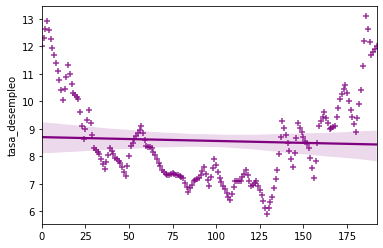

In [11]:
sns.regplot(x=data_total.index, y=data_total["tasa_desempleo"], marker='+', color = "purple")
# sns.regplot(x=X_train_sc.index, y=X_train_sc[3], marker='+', color = "red")
# sns.regplot(x=data_total["badlar"], y=data_total["tasa_incobrabilidad"], color = "red")

In [12]:
# Análisis de outliers
# Histograma  y boxplot

### 3- Entrenamiento de modelos

#### 3.1 - Regresión Lineal

In [13]:
# Stats Model
import statsmodels.api as sm
import statsmodels.formula.api as smf

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

lm = sm.OLS(y_train,X_train_sm).fit()  

y_pred_sm = lm.predict(X_test_sm)

print(lm.summary())
print ("r2_score:", r2_score(y_test, y_pred_sm))


                             OLS Regression Results                            
Dep. Variable:     tasa_incobrabilidad   R-squared:                       0.485
Model:                             OLS   Adj. R-squared:                  0.473
Method:                  Least Squares   F-statistic:                     41.12
Date:                 Sat, 27 Mar 2021   Prob (F-statistic):           8.59e-19
Time:                         10:35:48   Log-Likelihood:                -230.09
No. Observations:                  135   AIC:                             468.2
Df Residuals:                      131   BIC:                             479.8
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.792e-22   

In [14]:
#Regresión Lineal

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

print("Regresión Lineal sin SC:")
print("MSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Score r2: ", r2_score(y_test, y_pred))


Regresión Lineal sin SC:
MSE:  0.5617957280425193
Score r2:  0.8603632286239985


In [15]:
#Regresión Lineal con SC

linreg = LinearRegression(fit_intercept=True)
linreg.fit(X_train_sc, y_train)
y_pred = linreg.predict(X_test_sc)

print("Regresión Lineal con SC:")
print("MSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

print ("\nTest:")
print ('MAE:', mean_absolute_error(y_test, y_pred).round(5))
print ('MSE:', mean_squared_error(y_test, y_pred).round(5))
print ('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)).round(5))
print ('R2:', r2_score(y_test, y_pred).round(5))

Regresión Lineal con SC:
MSE:  0.3750876920730454

Test:
MAE: 0.26691
MSE: 0.14069
RMSE: 0.37509
R2: 0.93775


In [16]:
linreg.coef_

array([-1.38793816e+00, -4.61907998e-02,  1.54865319e+01, -3.31616518e+01,
       -1.45253484e+01, -2.03088618e-01,  6.14581177e+01,  1.11189685e+01,
       -1.32898787e+01, -2.64359650e+00,  2.39819296e+00, -2.87454753e+01,
        3.21613734e-01,  1.03284030e+00,  3.69366180e+00, -1.29247599e+00])

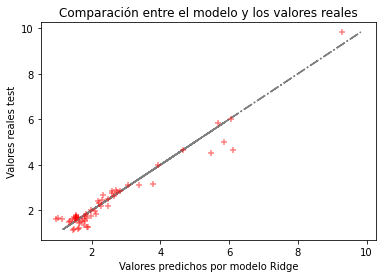

EMC: 0.1406907767446837
r2_score: 0.93775441382183


In [17]:
# Graficamos el modelo

plt.scatter(y_pred, y_test, s=30, c='r',alpha=0.5, marker='+', zorder=10)
plt.plot(y_test,y_test, '-.',c='grey')
plt.xlabel("Valores predichos por modelo Ridge")
plt.ylabel("Valores reales test")
plt.title('Comparación entre el modelo y los valores reales')
plt.show()
print ("EMC:", mean_squared_error(y_test, y_pred))
print ("r2_score:", r2_score(y_test, y_pred))

Text(0, 0.5, 'Index')

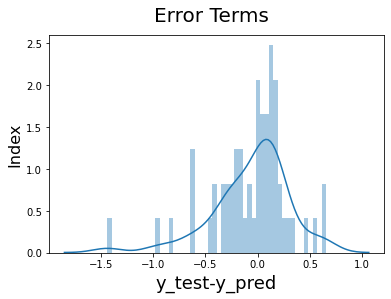

In [18]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label

#### 3.2 - Regularización Ridge

In [19]:

rlm = linear_model.RidgeCV(alphas=np.linspace(0,0.1, 1000), cv=5, normalize=True,scoring='r2')

ridge_model = rlm.fit(X_train_sc, y_train)

y_pred_ridge = ridge_model.predict(X_test_sc)

print ("R2 train:", ridge_model.score(X_train_sc, y_train))
print("Best alpha: ", ridge_model.alpha_)

print ("\nTest:")
print ('MAE:', mean_absolute_error(y_test, y_pred_ridge).round(5))
print ('MSE:', mean_squared_error(y_test, y_pred_ridge).round(5))
print ('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_ridge)).round(5))
print ('R2:', r2_score(y_test, y_pred_ridge).round(5))

R2 train: 0.936536877820001
Best alpha:  0.0026026026026026027

Test:
MAE: 0.32818
MSE: 0.20822
RMSE: 0.45631
R2: 0.90788


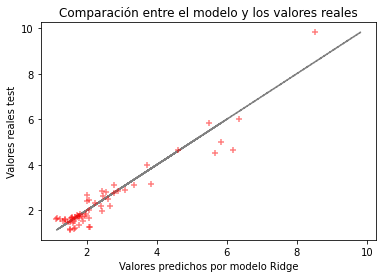

EMC: 0.20821578726522935
r2_score: 0.9078794358112527


In [20]:
# Graficamos el modelo

plt.scatter(y_pred_ridge, y_test, s=30, c='r',alpha=0.5, marker='+', zorder=10)
plt.plot(y_test,y_test, '-.',c='grey')
plt.xlabel("Valores predichos por modelo Ridge")
plt.ylabel("Valores reales test")
plt.title('Comparación entre el modelo y los valores reales')
plt.show()
print ("EMC:", mean_squared_error(y_test, y_pred_ridge))
print ("r2_score:", r2_score(y_test, y_pred_ridge))


Text(0, 0.5, 'Index')

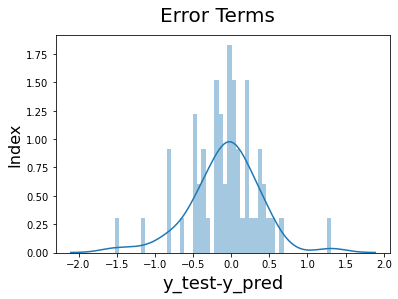

In [21]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred_ridge),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label

#### 3.3 - Regularización Lasso

In [22]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(alphas=np.linspace(0.00001,0.1, 1000), cv=3, normalize=True, n_jobs=-1)

lasso_model = lasso.fit(X_train_sc, y_train)

y_pred_lasso = lasso_model.predict(X_test_sc)

print ("r^2 train:", lasso_model.score(X_train_sc, y_train).round(5))
print("Best alpha: ", lasso_model.alpha_)


print ("\nTest:")
print ('MAE: \t', mean_absolute_error(y_test, y_pred_lasso).round(5))
print ('MSE: \t', mean_squared_error(y_test, y_pred_lasso).round(5))
print ('RMSE: \t', np.sqrt(mean_squared_error(y_test, y_pred_lasso)).round(5))
print ('R2: \t', r2_score(y_test, y_pred_lasso).round(5))

r^2 train: 0.93784
Best alpha:  0.0003102702702702703

Test:
MAE: 	 0.32511
MSE: 	 0.21192
RMSE: 	 0.46034
R2: 	 0.90624


In [23]:
for column in range(0,len(X_train.columns)):
    print(f"{X_train.columns[column]}: \t{round(lasso_model.coef_[column],5)}")

badlar: 	-0.27027
tc: 	-0.0
ipc: 	-0.36117
pbi_real: 	-1.86716
pbi_nominal: 	-0.0
tasa_desempleo: 	-1.28365
pbi_real_2: 	0.0
pbi_nominal_2: 	0.14691
ipc_2: 	-0.0
tasa_desempleo_2: 	0.0
badlar_2: 	0.14481
pbi_real_3: 	1.19177
pbi_nominal_3: 	3.13847
ipc_3: 	-2.79587
tasa_desempleo_3: 	2.38869
badlar_3: 	0.0


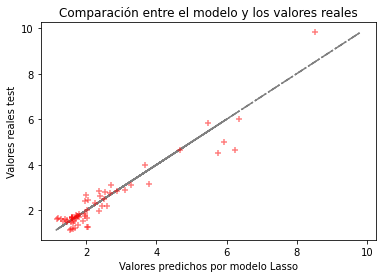

EMC: 0.21191637389255044
r2_score: 0.9062421914292794


In [24]:
plt.scatter(y_pred_lasso, y_test, s=30, c='r',alpha=0.5, marker='+', zorder=10)
plt.plot(y_test,y_test, '-.',c='grey')
plt.xlabel("Valores predichos por modelo Lasso")
plt.ylabel("Valores reales test")
plt.title('Comparación entre el modelo y los valores reales')
plt.show()
print ("EMC:", mean_squared_error(y_test, y_pred_lasso))
print ("r2_score:", r2_score(y_test, y_pred_lasso))

Text(0, 0.5, 'Index')

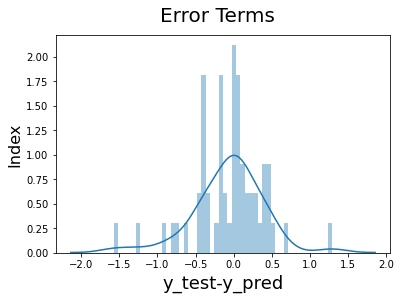

In [25]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred_lasso),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label

#### 3.4 - ElasticNet

In [26]:
from sklearn.linear_model import ElasticNetCV as eNetCv

eNet = linear_model.ElasticNetCV(l1_ratio=np.linspace(0, 1, 100), cv=3, alphas=np.linspace(0.00001,1, 1000), n_jobs=-1)

eNet_model = eNet.fit(X_train_sc, y_train)

y_pred_eNet = eNet_model.predict(X_test_sc)

print ("r^2 train:", eNet_model.score(X_train_sc, y_train))
print("Best l1_ratio: ", eNet_model.l1_ratio_)
print("Best alpha: ", eNet_model.alpha_)

print ("\nTest:")
print ('MAE:', mean_absolute_error(y_test, y_pred_eNet).round(5))
print ('MSE:', mean_squared_error(y_test, y_pred_eNet).round(5))
print ('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_eNet)).round(5))
print ('R2:', r2_score(y_test, y_pred_eNet).round(5))

r^2 train: 0.9383331996992991
Best l1_ratio:  0.0
Best alpha:  0.002011981981981982

Test:
MAE: 0.31941
MSE: 0.20187
RMSE: 0.4493
R2: 0.91069


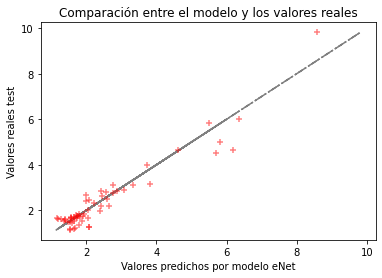

EMC: 0.20187066021304265
r2_score: 0.9106866998116148


In [27]:
plt.scatter(y_pred_eNet, y_test, s=30, c='r',alpha=0.5, marker='+', zorder=10)
plt.plot(y_test,y_test, '-.',c='grey')
plt.xlabel("Valores predichos por modelo eNet")
plt.ylabel("Valores reales test")
plt.title('Comparación entre el modelo y los valores reales')
plt.show()
print ("EMC:", mean_squared_error(y_test, y_pred_eNet))
print ("r2_score:", r2_score(y_test, y_pred_eNet))

### 4- Tuneo de hiperparámetros 

4.1 - Aplicación de GridSearch

Debido a la simplicidad del modelo, el cual es una regresión lineal múltiple, sin variables categóricas, el único parámetro a tunear es alpha, por lo tanto se vuelve innecesario realizar GridSearch, en vez se utiliza Ridge CV y LassoCV


n: 1:
MAE: 0.53838
MSE: 0.5166
RMSE: 0.71875
R2: 0.77144


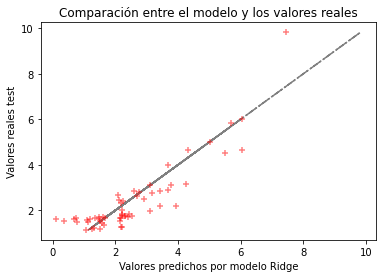


n: 2:
MAE: 0.27437
MSE: 0.16775
RMSE: 0.40958
R2: 0.92578


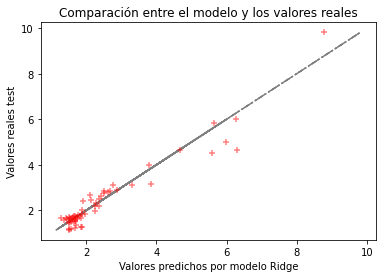


n: 3:
MAE: 0.27024
MSE: 0.14347
RMSE: 0.37878
R2: 0.93652


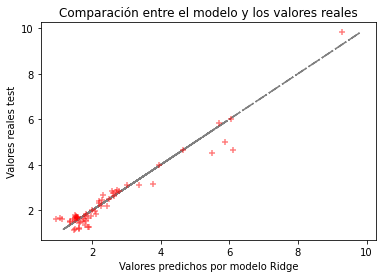


n: 4:
MAE: 0.29072
MSE: 0.13661
RMSE: 0.36961
R2: 0.93956


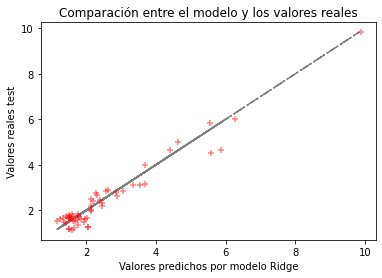


n: 5:
MAE: 0.30716
MSE: 0.24833
RMSE: 0.49833
R2: 0.89013


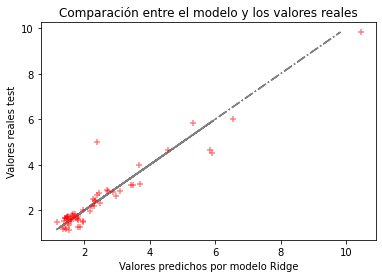


n: 6:
MAE: 0.33124
MSE: 0.33915
RMSE: 0.58237
R2: 0.84995


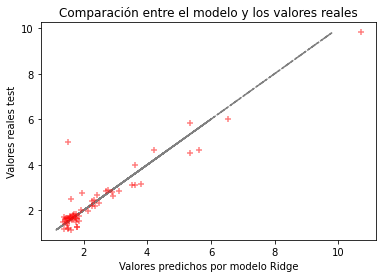


n: 7:
MAE: 0.33007
MSE: 0.34761
RMSE: 0.58959
R2: 0.84621


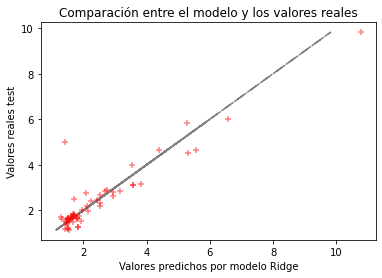


n: 8:
MAE: 0.33918
MSE: 0.26159
RMSE: 0.51146
R2: 0.88427


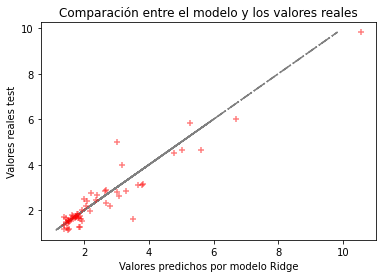


n: 9:
MAE: 0.32059
MSE: 0.20735
RMSE: 0.45536
R2: 0.90826


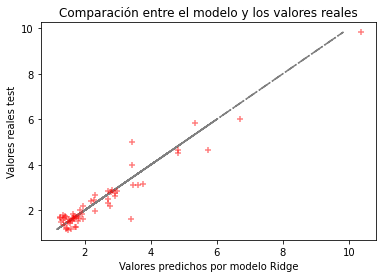


n: 10:
MAE: 0.30579
MSE: 0.18839
RMSE: 0.43404
R2: 0.91665


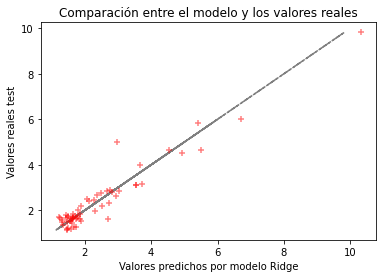


n: 11:
MAE: 0.3416
MSE: 0.41848
RMSE: 0.6469
R2: 0.81485


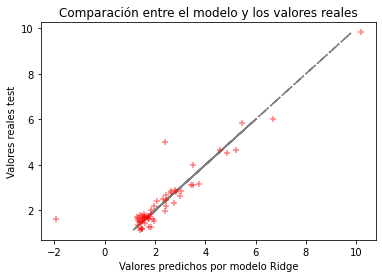


n: 12:
MAE: 0.335
MSE: 0.77588
RMSE: 0.88084
R2: 0.65673


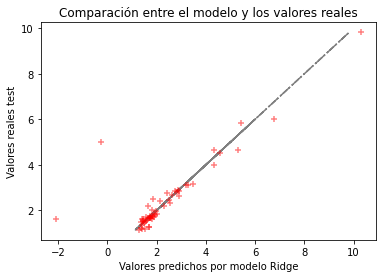


n: 13:
MAE: 0.69596
MSE: 10.13838
RMSE: 3.18408
R2: -3.48551


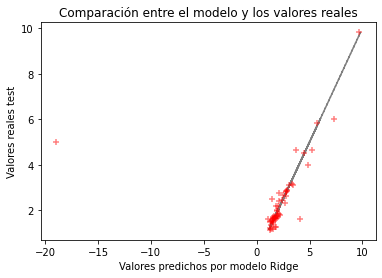


n: 14:
MAE: 0.65046
MSE: 7.61977
RMSE: 2.76039
R2: -2.3712


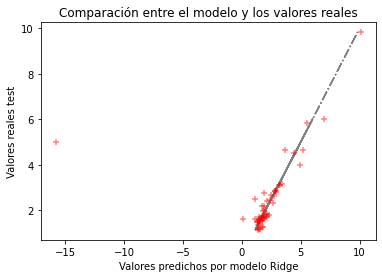


n: 15:
MAE: 0.4316
MSE: 1.35401
RMSE: 1.16362
R2: 0.40095


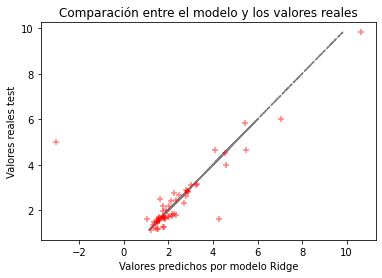


n: 16:
MAE: 0.82723
MSE: 9.16332
RMSE: 3.0271
R2: -3.05411


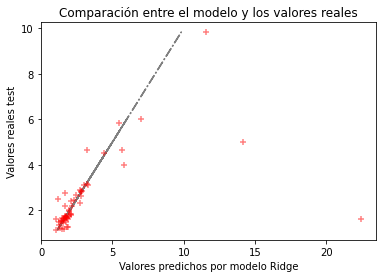


n: 17:
MAE: 0.5249
MSE: 1.53929
RMSE: 1.24068
R2: 0.31897


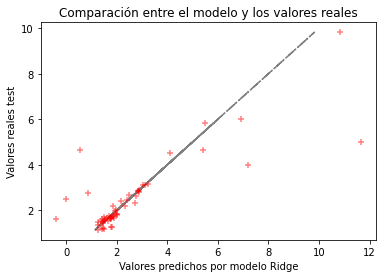


n: 18:
MAE: 0.5812
MSE: 3.8228
RMSE: 1.9552
R2: -0.69131


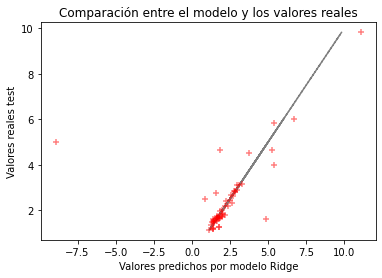


n: 19:
MAE: 1.07599
MSE: 19.59783
RMSE: 4.42694
R2: -7.67063


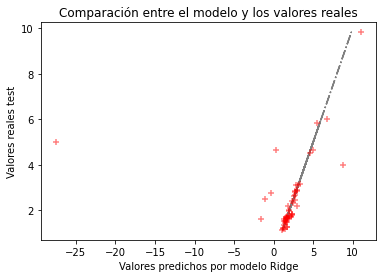

In [28]:
# Luego de visualizar las primeras predicciones, y compararlas con los valores reales, vemos que aparentemente existe una
# componente cuadrática en la relación entre y_real e y_pred. Debido a que pbi_real es una de las componentes con mayor peso, 
# le damos énfasis generando un nuevo feature pbi_real_2 = pbi_real**2

data_total = data_1.merge(data_2, how="left", on="Mes")
data_total.interpolate(method='linear', inplace = True)
data_total = data_total[['Mes', 'Badlar en $', 'TC', 'IPC', 'PBI Real', 'PBI Nominal', 'Tasa de Desempleo', 'Tasa de Incobrabilidad - mora']]
data_total.columns = ['mes', 'badlar', 'tc', 'ipc', 'pbi_real', 'pbi_nominal', 'tasa_desempleo', 'tasa_incobrabilidad' ]

for n in range(1,20):

    if n>1:
        data_total[f'pbi_real_{n}'] = data_total['pbi_real']**n
        data_total[f'pbi_nominal_{n}'] = data_total['pbi_nominal']**n
        data_total[f'ipc_{n}'] = data_total['ipc']**2
        data_total[f'tasa_desempleo_{n}'] = data_total['tasa_desempleo']**n
        data_total[f'badlar_{n}'] = data_total['badlar']**n

    X = data_total.drop(["tasa_incobrabilidad", "mes"],axis=1)
    y = data_total["tasa_incobrabilidad"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

    # Aplicamos StandardScaler

    sc = StandardScaler()
    X_train_sc = pd.DataFrame(sc.fit_transform(X_train),columns=X_train.columns)
    X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

    #Regresión Lineal con SC

    linreg = LinearRegression(fit_intercept=True)
    linreg.fit(X_train_sc, y_train)
    y_pred = linreg.predict(X_test_sc)

   # print("Regresión Lineal con SC:")

    print (f"\nn: {n}:")
    print ('MAE:', mean_absolute_error(y_test, y_pred).round(5))
    print ('MSE:', mean_squared_error(y_test, y_pred).round(5))
    print ('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)).round(5))
    print ('R2:', r2_score(y_test, y_pred).round(5))
    
    plt.scatter(y_pred, y_test, s=30, c='r',alpha=0.5, marker='+', zorder=10)
    plt.plot(y_test,y_test, '-.',c='grey')
    plt.xlabel("Valores predichos por modelo Ridge")
    plt.ylabel("Valores reales test")
    plt.title('Comparación entre el modelo y los valores reales')
    plt.show()
    
   




n: 1:
R2 train: 0.8383752058416272
Best alpha:  0.0002002002002002002

Test:
MAE: 0.53303
MSE: 0.50493
RMSE: 0.71058
R2: 0.7766


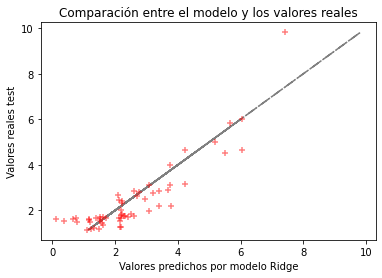

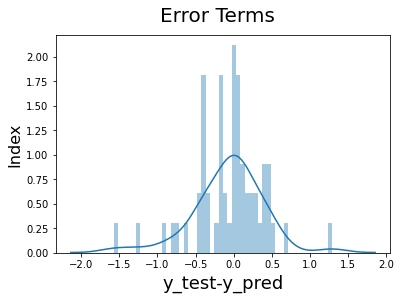

badlar: 	-0.39688
tc: 	1.69754
ipc: 	-6.61255
pbi_real: 	-0.83617
pbi_nominal: 	5.37866
tasa_desempleo: 	1.083


n: 2:
R2 train: 0.9391036261432177
Best alpha:  0.0001001001001001001

Test:
MAE: 0.3025
MSE: 0.18671
RMSE: 0.43209
R2: 0.9174


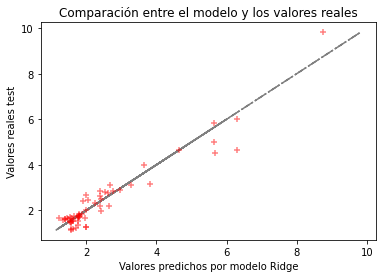

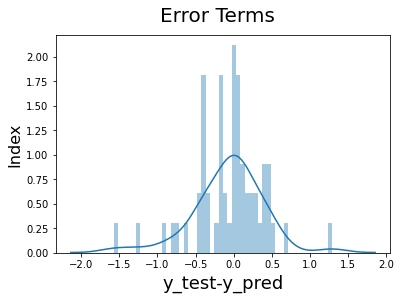

badlar: 	-0.34728
tc: 	-0.05736
ipc: 	2.95323
pbi_real: 	-4.40532
pbi_nominal: 	-3.5775
tasa_desempleo: 	-4.06847
pbi_real_2: 	3.73535
pbi_nominal_2: 	6.57452
ipc_2: 	-5.63591
tasa_desempleo_2: 	4.99577
badlar_2: 	0.13937


n: 3:
R2 train: 0.9342305953235398
Best alpha:  0.0016016016016016017

Test:
MAE: 0.32772
MSE: 0.2052
RMSE: 0.45299
R2: 0.90921


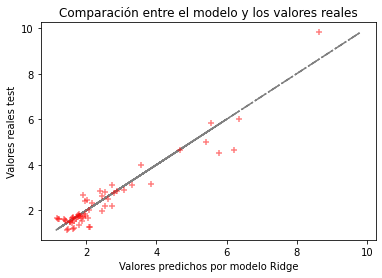

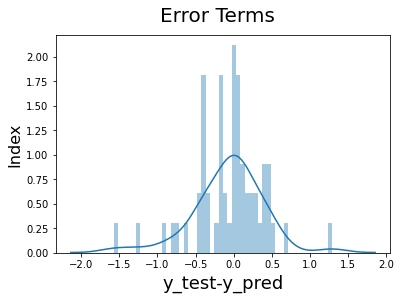

badlar: 	-0.85461
tc: 	-0.0444
ipc: 	-0.26043
pbi_real: 	-1.87704
pbi_nominal: 	0.45245
tasa_desempleo: 	-1.43292
pbi_real_2: 	-0.11829
pbi_nominal_2: 	2.38179
ipc_2: 	-1.93768
tasa_desempleo_2: 	0.27386
badlar_2: 	1.01308
pbi_real_3: 	1.25574
pbi_nominal_3: 	1.65774
ipc_3: 	-1.93768
tasa_desempleo_3: 	2.17451
badlar_3: 	-0.3465


n: 4:
R2 train: 0.9625263758580561
Best alpha:  0.0

Test:
MAE: 0.29072
MSE: 0.13661
RMSE: 0.36961
R2: 0.93956


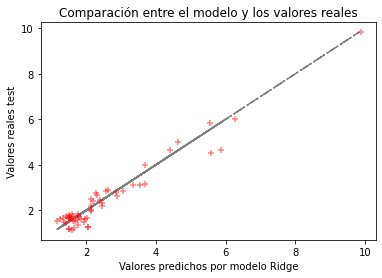

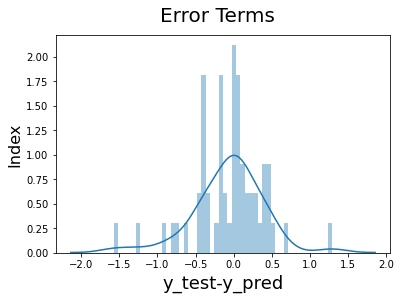

badlar: 	-6.43993
tc: 	-0.524
ipc: 	12.33664
pbi_real: 	-324.38553
pbi_nominal: 	-13.23785
tasa_desempleo: 	51.44308
pbi_real_2: 	964.7785
pbi_nominal_2: 	13.89433
ipc_2: 	-3.30067
tasa_desempleo_2: 	-169.05305
badlar_2: 	20.38633
pbi_real_3: 	-964.71135
pbi_nominal_3: 	-4.13544
ipc_3: 	-3.30067
tasa_desempleo_3: 	184.78919
badlar_3: 	-23.77706
pbi_real_4: 	323.89084
pbi_nominal_4: 	1.53307
ipc_4: 	-3.30067
tasa_desempleo_4: 	-66.47318
badlar_4: 	9.52033


n: 5:
R2 train: 0.9743818029787071
Best alpha:  0.0

Test:
MAE: 0.30716
MSE: 0.24833
RMSE: 0.49833
R2: 0.89013


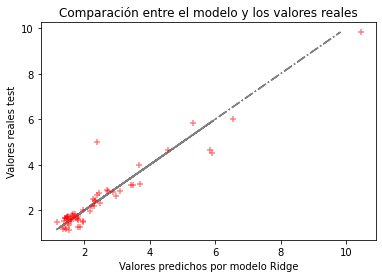

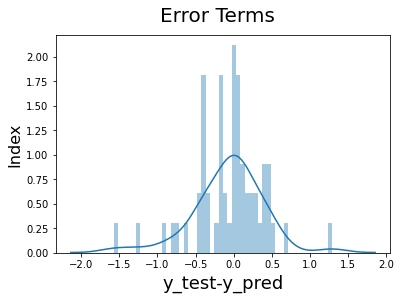

badlar: 	-13.35174
tc: 	0.01335
ipc: 	16.50451
pbi_real: 	-470.52673
pbi_nominal: 	-11.31257
tasa_desempleo: 	-650.49415
pbi_real_2: 	1671.23972
pbi_nominal_2: 	-22.74712
ipc_2: 	-3.26956
tasa_desempleo_2: 	2773.21286
badlar_2: 	54.71459
pbi_real_3: 	-2218.56228
pbi_nominal_3: 	89.91641
ipc_3: 	-3.26956
tasa_desempleo_3: 	-4514.79483
badlar_3: 	-91.70601
pbi_real_4: 	1296.8976
pbi_nominal_4: 	-94.20999
ipc_4: 	-3.26956
tasa_desempleo_4: 	3318.18545
badlar_4: 	69.63515
pbi_real_5: 	-279.44124
pbi_nominal_5: 	35.00419
ipc_5: 	-3.26956
tasa_desempleo_5: 	-925.42687
badlar_5: 	-19.80405


n: 6:
R2 train: 0.9785170305947366
Best alpha:  0.0

Test:
MAE: 0.33124
MSE: 0.33915
RMSE: 0.58237
R2: 0.84995


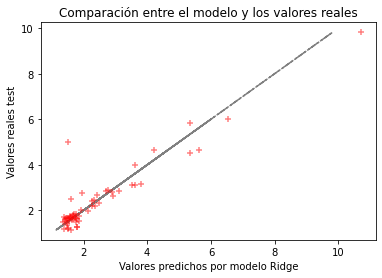

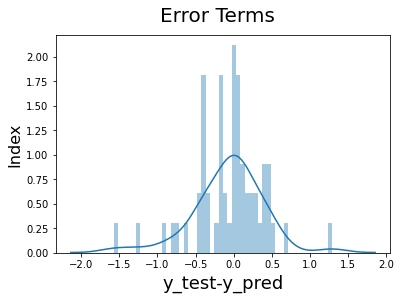

badlar: 	-20.69331
tc: 	0.16852
ipc: 	9.49399
pbi_real: 	195.8431
pbi_nominal: 	-14.69896
tasa_desempleo: 	1042.28733
pbi_real_2: 	-1480.09759
pbi_nominal_2: 	55.5777
ipc_2: 	-1.8253
tasa_desempleo_2: 	-6086.00771
badlar_2: 	106.86451
pbi_real_3: 	3779.33117
pbi_nominal_3: 	-200.52829
ipc_3: 	-1.8253
tasa_desempleo_3: 	14401.94829
badlar_3: 	-253.63758
pbi_real_4: 	-4444.31734
pbi_nominal_4: 	405.58279
ipc_4: 	-1.8253
tasa_desempleo_4: 	-17233.99499
badlar_4: 	324.59859
pbi_real_5: 	2484.60875
pbi_nominal_5: 	-371.91952
ipc_5: 	-1.8253
tasa_desempleo_5: 	10404.29386
badlar_5: 	-217.9567
pbi_real_6: 	-535.75719
pbi_nominal_6: 	125.71735
ipc_6: 	-1.8253
tasa_desempleo_6: 	-2527.92809
badlar_6: 	60.15307


n: 7:
R2 train: 0.9792268885540009
Best alpha:  0.0

Test:
MAE: 0.33007
MSE: 0.34761
RMSE: 0.58959
R2: 0.84621


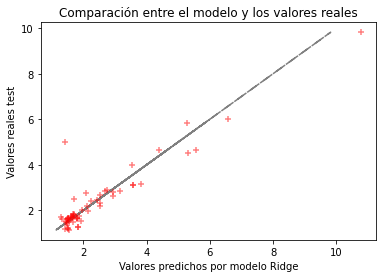

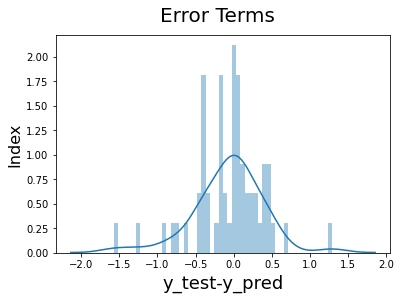

badlar: 	-32.43521
tc: 	-0.28592
ipc: 	4.87322
pbi_real: 	-51050.26596
pbi_nominal: 	-18.32858
tasa_desempleo: 	1841.45527
pbi_real_2: 	316173.7802
pbi_nominal_2: 	135.34568
ipc_2: 	-0.93716
tasa_desempleo_2: 	-11190.21688
badlar_2: 	204.76735
pbi_real_3: 	-822328.91128
pbi_nominal_3: 	-576.25483
ipc_3: 	-0.9442
tasa_desempleo_3: 	28287.82179
badlar_3: 	-631.65334
pbi_real_4: 	1148457.77888
pbi_nominal_4: 	1300.48155
ipc_4: 	-0.94771
tasa_desempleo_4: 	-37770.6319
badlar_4: 	1127.69251
pbi_real_5: 	-907488.5965
pbi_nominal_5: 	-1526.38772
ipc_5: 	-0.94765
tasa_desempleo_5: 	27763.84883
badlar_5: 	-1175.28776
pbi_real_6: 	384346.79118
pbi_nominal_6: 	891.47304
ipc_6: 	-0.94766
tasa_desempleo_6: 	-10454.07244
badlar_6: 	659.57387
pbi_real_7: 	-68110.81115
pbi_nominal_7: 	-205.02054
ipc_7: 	-0.94766
tasa_desempleo_7: 	1522.34867
badlar_7: 	-153.33099


n: 8:
R2 train: 0.9508814167024494
Best alpha:  0.0001001001001001001

Test:
MAE: 0.32095
MSE: 0.17587
RMSE: 0.41936
R2: 0.92219


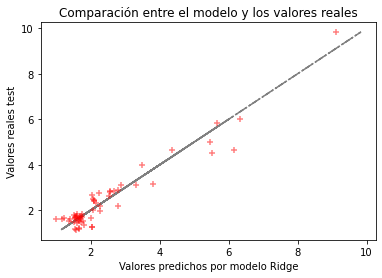

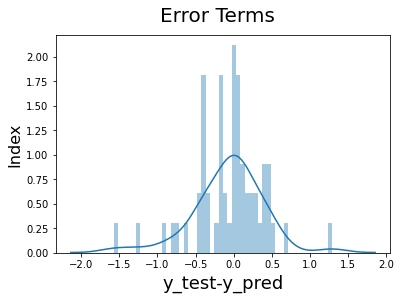

badlar: 	-2.4943
tc: 	-0.52986
ipc: 	4.41694
pbi_real: 	-3.62449
pbi_nominal: 	-4.11209
tasa_desempleo: 	0.99569
pbi_real_2: 	0.08083
pbi_nominal_2: 	3.98721
ipc_2: 	-0.84018
tasa_desempleo_2: 	-1.59083
badlar_2: 	4.78235
pbi_real_3: 	1.63537
pbi_nominal_3: 	3.01364
ipc_3: 	-0.84018
tasa_desempleo_3: 	-1.51342
badlar_3: 	-0.9338
pbi_real_4: 	1.73863
pbi_nominal_4: 	1.06201
ipc_4: 	-0.84018
tasa_desempleo_4: 	0.10506
badlar_4: 	-2.02565
pbi_real_5: 	1.0332
pbi_nominal_5: 	-0.63989
ipc_5: 	-0.84018
tasa_desempleo_5: 	1.91915
badlar_5: 	-0.81977
pbi_real_6: 	0.07499
pbi_nominal_6: 	-1.38071
ipc_6: 	-0.84018
tasa_desempleo_6: 	2.64442
badlar_6: 	0.23406
pbi_real_7: 	-0.68136
pbi_nominal_7: 	-0.82082
ipc_7: 	-0.84018
tasa_desempleo_7: 	1.25317
badlar_7: 	0.59555
pbi_real_8: 	-0.88528
pbi_nominal_8: 	1.06697
ipc_8: 	-0.84018
tasa_desempleo_8: 	-2.94115
badlar_8: 	0.43292


n: 9:
R2 train: 0.9528286786077614
Best alpha:  0.0001001001001001001

Test:
MAE: 0.32294
MSE: 0.17872
RMSE: 0.42275
R2:

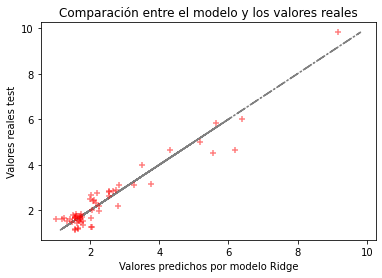

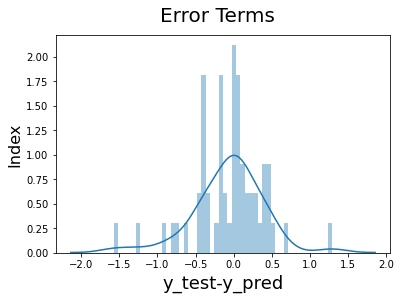

badlar: 	-2.46481
tc: 	-0.48661
ipc: 	4.60144
pbi_real: 	-3.56021
pbi_nominal: 	-4.19338
tasa_desempleo: 	1.64391
pbi_real_2: 	0.07174
pbi_nominal_2: 	3.85183
ipc_2: 	-0.77262
tasa_desempleo_2: 	-1.57797
badlar_2: 	4.73788
pbi_real_3: 	1.58415
pbi_nominal_3: 	3.18595
ipc_3: 	-0.77262
tasa_desempleo_3: 	-2.15028
badlar_3: 	-0.90716
pbi_real_4: 	1.67524
pbi_nominal_4: 	1.4909
ipc_4: 	-0.77262
tasa_desempleo_4: 	-0.86958
badlar_4: 	-2.02415
pbi_real_5: 	0.98511
pbi_nominal_5: 	-0.26793
ipc_5: 	-0.77262
tasa_desempleo_5: 	1.14718
badlar_5: 	-0.85997
pbi_real_6: 	0.06632
pbi_nominal_6: 	-1.40564
ipc_6: 	-0.77262
tasa_desempleo_6: 	2.73296
badlar_6: 	0.18986
pbi_real_7: 	-0.63035
pbi_nominal_7: 	-1.51661
ipc_7: 	-0.77262
tasa_desempleo_7: 	2.88032
badlar_7: 	0.58132
pbi_real_8: 	-0.75838
pbi_nominal_8: 	-0.49166
ipc_8: 	-0.77262
tasa_desempleo_8: 	0.85362
badlar_8: 	0.46358
pbi_real_9: 	-0.06972
pbi_nominal_9: 	1.61383
ipc_9: 	-0.77262
tasa_desempleo_9: 	-3.78627
badlar_9: 	0.03712


In [29]:
data_total = data_1.merge(data_2, how="left", on="Mes")
data_total.interpolate(method='linear', inplace = True)
data_total = data_total[['Mes', 'Badlar en $', 'TC', 'IPC', 'PBI Real', 'PBI Nominal', 'Tasa de Desempleo', 'Tasa de Incobrabilidad - mora']]
data_total.columns = ['mes', 'badlar', 'tc', 'ipc', 'pbi_real', 'pbi_nominal', 'tasa_desempleo', 'tasa_incobrabilidad' ]

for n in range(1,10):

    if n>1:
        data_total[f'pbi_real_{n}'] = data_total['pbi_real']**n
        data_total[f'pbi_nominal_{n}'] = data_total['pbi_nominal']**n
        data_total[f'ipc_{n}'] = data_total['ipc']**2
        data_total[f'tasa_desempleo_{n}'] = data_total['tasa_desempleo']**n
        data_total[f'badlar_{n}'] = data_total['badlar']**n

    X = data_total.drop(["tasa_incobrabilidad", "mes"],axis=1)
    y = data_total["tasa_incobrabilidad"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

    # Aplicamos StandardScaler

    sc = StandardScaler()
    X_train_sc = pd.DataFrame(sc.fit_transform(X_train),columns=X_train.columns)
    X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

    #Regresión Lineal con SC

    rlm = linear_model.RidgeCV(alphas=np.linspace(0,0.1, 1000), cv=5, normalize=True,scoring='r2')
    ridge_model = rlm.fit(X_train_sc, y_train)
    y_pred_ridge = ridge_model.predict(X_test_sc)
    
    print(f"\n\nn: {n}:")
    print("R2 train:", ridge_model.score(X_train_sc, y_train))
    print("Best alpha: ", ridge_model.alpha_)
    
    print("\nTest:")
    print('MAE:', mean_absolute_error(y_test, y_pred_ridge).round(5))
    print('MSE:', mean_squared_error(y_test, y_pred_ridge).round(5))
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_ridge)).round(5))
    print('R2:', r2_score(y_test, y_pred_ridge).round(5))
  
    plt.scatter(y_pred_ridge, y_test, s=30, c='r',alpha=0.5, marker='+', zorder=10)
    plt.plot(y_test,y_test, '-.',c='grey')
    plt.xlabel("Valores predichos por modelo Ridge")
    plt.ylabel("Valores reales test")
    plt.title('Comparación entre el modelo y los valores reales')
    plt.show()
    
    # Plotting the error terms to understand the distribution.
    fig = plt.figure()
    sns.distplot((y_test-y_pred_lasso),bins=50)
    fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
    plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
    plt.ylabel('Index', fontsize=16)                          # Y-label
    plt.show()
    
    for column in range(0,len(X_train.columns)):
        print(f"{X_train.columns[column]}: \t{round(ridge_model.coef_[column],5)}")



n: 1:
R2 train: 0.83874
Best alpha:  1e-05

Test:
MAE: 	 0.53687
MSE: 	 0.51094
RMSE: 	 0.7148
R2: 	 0.77395


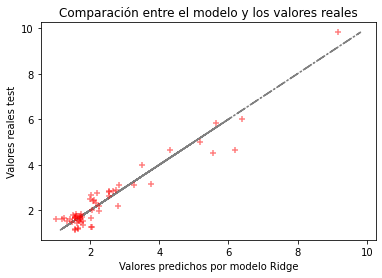

badlar: 	-0.43104
tc: 	1.76888
ipc: 	-6.95094
pbi_real: 	-0.84398
pbi_nominal: 	5.67779
tasa_desempleo: 	1.07855

n: 2:
R2 train: 0.93353
Best alpha:  0.0001100900900900901

Test:
MAE: 	 0.35013
MSE: 	 0.22612
RMSE: 	 0.47552
R2: 	 0.89996


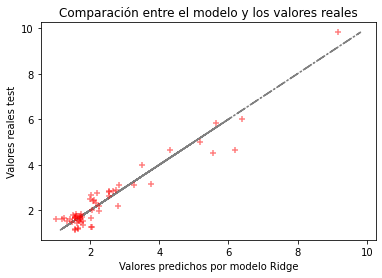

badlar: 	-0.37189
tc: 	-0.0004
ipc: 	-0.9271
pbi_real: 	-2.35446
pbi_nominal: 	-0.01388
tasa_desempleo: 	-4.22797
pbi_real_2: 	1.64908
pbi_nominal_2: 	5.10795
ipc_2: 	-3.89406
tasa_desempleo_2: 	5.27029
badlar_2: 	0.13826

n: 3:
R2 train: 0.93322
Best alpha:  0.0003102702702702703

Test:
MAE: 	 0.3361
MSE: 	 0.21646
RMSE: 	 0.46526
R2: 	 0.90423


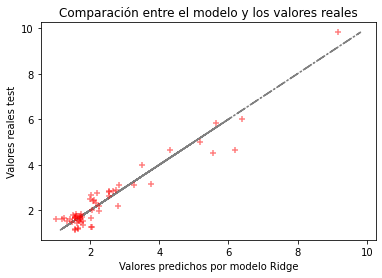

badlar: 	-0.37568
tc: 	-0.0
ipc: 	-0.0
pbi_real: 	-1.69007
pbi_nominal: 	-0.0
tasa_desempleo: 	-1.28286
pbi_real_2: 	0.0
pbi_nominal_2: 	2.91117
ipc_2: 	-2.56529
tasa_desempleo_2: 	-0.0
badlar_2: 	0.21167
pbi_real_3: 	0.97606
pbi_nominal_3: 	1.51492
ipc_3: 	-1.62191
tasa_desempleo_3: 	2.37551
badlar_3: 	0.01185

n: 4:
R2 train: 0.93425
Best alpha:  0.0003102702702702703

Test:
MAE: 	 0.33022
MSE: 	 0.21025
RMSE: 	 0.45853
R2: 	 0.90698


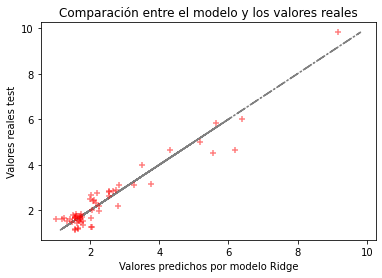

badlar: 	-0.32743
tc: 	-0.0
ipc: 	-0.0
pbi_real: 	-1.577
pbi_nominal: 	-0.0
tasa_desempleo: 	-0.599
pbi_real_2: 	-0.0
pbi_nominal_2: 	2.94603
ipc_2: 	-2.59148
tasa_desempleo_2: 	-0.0
badlar_2: 	0.13751
pbi_real_3: 	0.0
pbi_nominal_3: 	1.49635
ipc_3: 	-1.56486
tasa_desempleo_3: 	0.0
badlar_3: 	0.05373
pbi_real_4: 	0.8406
pbi_nominal_4: 	0.0
ipc_4: 	-0.02786
tasa_desempleo_4: 	1.68118
badlar_4: 	0.0

n: 5:
R2 train: 0.93239
Best alpha:  0.00041036036036036044

Test:
MAE: 	 0.33517
MSE: 	 0.21318
RMSE: 	 0.46171
R2: 	 0.90568


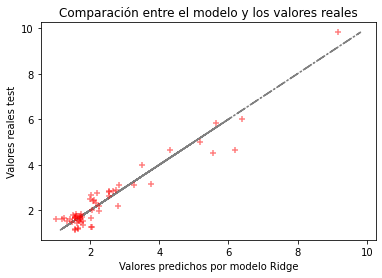

badlar: 	-0.23212
tc: 	-0.0
ipc: 	-0.0
pbi_real: 	-1.40917
pbi_nominal: 	-0.0
tasa_desempleo: 	-0.19472
pbi_real_2: 	-0.0
pbi_nominal_2: 	2.77159
ipc_2: 	-2.44767
tasa_desempleo_2: 	-0.0
badlar_2: 	0.0
pbi_real_3: 	0.0
pbi_nominal_3: 	1.45196
ipc_3: 	-1.44045
tasa_desempleo_3: 	0.0
badlar_3: 	0.13664
pbi_real_4: 	0.0
pbi_nominal_4: 	0.0
ipc_4: 	-0.0696
tasa_desempleo_4: 	0.0
badlar_4: 	0.0
pbi_real_5: 	0.67053
pbi_nominal_5: 	-0.0
ipc_5: 	-0.02651
tasa_desempleo_5: 	1.29616
badlar_5: 	0.0

n: 6:
R2 train: 0.93092
Best alpha:  0.0005104504504504506

Test:
MAE: 	 0.3342
MSE: 	 0.21915
RMSE: 	 0.46814
R2: 	 0.90304


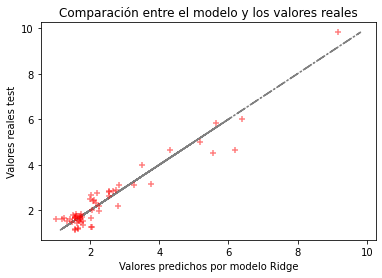

badlar: 	-0.1913
tc: 	-0.0
ipc: 	-0.0
pbi_real: 	-1.35096
pbi_nominal: 	0.0
tasa_desempleo: 	-0.0
pbi_real_2: 	-0.0
pbi_nominal_2: 	2.28416
ipc_2: 	-1.79713
tasa_desempleo_2: 	0.0
badlar_2: 	0.0
pbi_real_3: 	0.0
pbi_nominal_3: 	1.77129
ipc_3: 	-1.75725
tasa_desempleo_3: 	0.0
badlar_3: 	0.13551
pbi_real_4: 	0.0
pbi_nominal_4: 	0.0
ipc_4: 	-0.06902
tasa_desempleo_4: 	0.0
badlar_4: 	0.0
pbi_real_5: 	0.0
pbi_nominal_5: 	-0.0
ipc_5: 	-0.00446
tasa_desempleo_5: 	0.02692
badlar_5: 	0.0
pbi_real_6: 	0.60137
pbi_nominal_6: 	-0.19384
ipc_6: 	-0.01091
tasa_desempleo_6: 	1.0637
badlar_6: 	0.0

n: 7:
R2 train: 0.94205
Best alpha:  1e-05

Test:
MAE: 	 0.31998
MSE: 	 0.19186
RMSE: 	 0.43802
R2: 	 0.91511


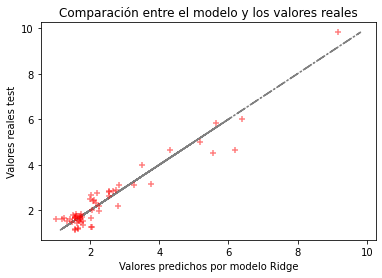

badlar: 	-1.40963
tc: 	-0.12023
ipc: 	0.37965
pbi_real: 	-2.12389
pbi_nominal: 	-0.53744
tasa_desempleo: 	-0.69541
pbi_real_2: 	0.74496
pbi_nominal_2: 	3.57807
ipc_2: 	-1.22446
tasa_desempleo_2: 	-0.24427
badlar_2: 	2.32927
pbi_real_3: 	-0.20261
pbi_nominal_3: 	0.52013
ipc_3: 	-1.75303
tasa_desempleo_3: 	0.51591
badlar_3: 	-0.14796
pbi_real_4: 	0.40871
pbi_nominal_4: 	1.19721
ipc_4: 	-1.36001
tasa_desempleo_4: 	0.87119
badlar_4: 	-1.13313
pbi_real_5: 	0.66205
pbi_nominal_5: 	0.61518
ipc_5: 	-0.51939
tasa_desempleo_5: 	0.73059
badlar_5: 	-0.56
pbi_real_6: 	0.14656
pbi_nominal_6: 	-0.26068
ipc_6: 	0.0
tasa_desempleo_6: 	0.16408
badlar_6: 	0.04361
pbi_real_7: 	-0.3354
pbi_nominal_7: 	-0.74441
ipc_7: 	0.46746
tasa_desempleo_7: 	-0.35004
badlar_7: 	0.67771

n: 8:
R2 train: 0.94321
Best alpha:  1e-05

Test:
MAE: 	 0.3289
MSE: 	 0.1946
RMSE: 	 0.44114
R2: 	 0.9139


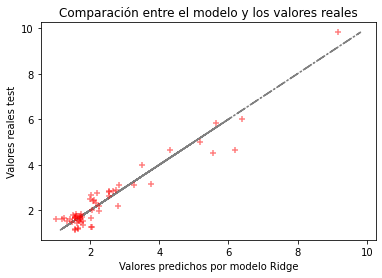

badlar: 	-1.56058
tc: 	-0.20622
ipc: 	0.37647
pbi_real: 	-2.24229
pbi_nominal: 	-0.57076
tasa_desempleo: 	-0.59176
pbi_real_2: 	0.86489
pbi_nominal_2: 	3.73016
ipc_2: 	-1.05287
tasa_desempleo_2: 	-0.48475
badlar_2: 	2.47972
pbi_real_3: 	-0.32851
pbi_nominal_3: 	0.3802
ipc_3: 	-1.57932
tasa_desempleo_3: 	0.36027
badlar_3: 	-0.00441
pbi_real_4: 	0.38344
pbi_nominal_4: 	1.08316
ipc_4: 	-1.24172
tasa_desempleo_4: 	0.89403
badlar_4: 	-0.96491
pbi_real_5: 	0.7617
pbi_nominal_5: 	0.57739
ipc_5: 	-0.56489
tasa_desempleo_5: 	0.95336
badlar_5: 	-0.75683
pbi_real_6: 	0.42381
pbi_nominal_6: 	-0.12892
ipc_6: 	-0.03872
tasa_desempleo_6: 	0.48701
badlar_6: 	-0.15395
pbi_real_7: 	-0.02458
pbi_nominal_7: 	-0.46037
ipc_7: 	0.02488
tasa_desempleo_7: 	0.00014
badlar_7: 	0.14296
pbi_real_8: 	-0.53202
pbi_nominal_8: 	-0.29519
ipc_8: 	0.18743
tasa_desempleo_8: 	-0.64502
badlar_8: 	0.6195

n: 9:
R2 train: 0.94415
Best alpha:  1e-05

Test:
MAE: 	 0.33714
MSE: 	 0.19862
RMSE: 	 0.44566
R2: 	 0.91213


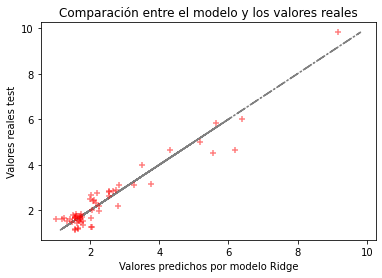

badlar: 	-1.62199
tc: 	-0.28179
ipc: 	0.39584
pbi_real: 	-2.28285
pbi_nominal: 	-0.60074
tasa_desempleo: 	-0.37884
pbi_real_2: 	0.98828
pbi_nominal_2: 	3.7684
ipc_2: 	-0.9966
tasa_desempleo_2: 	-0.70925
badlar_2: 	2.45692
pbi_real_3: 	-0.44726
pbi_nominal_3: 	0.43568
ipc_3: 	-1.50636
tasa_desempleo_3: 	0.10166
badlar_3: 	0.16248
pbi_real_4: 	0.24367
pbi_nominal_4: 	1.04133
ipc_4: 	-1.15588
tasa_desempleo_4: 	0.76619
badlar_4: 	-0.80291
pbi_real_5: 	0.73752
pbi_nominal_5: 	0.5269
ipc_5: 	-0.52324
tasa_desempleo_5: 	1.03782
badlar_5: 	-0.7993
pbi_real_6: 	0.57092
pbi_nominal_6: 	-0.15011
ipc_6: 	-0.03767
tasa_desempleo_6: 	0.77554
badlar_6: 	-0.33639
pbi_real_7: 	0.10861
pbi_nominal_7: 	-0.46747
ipc_7: 	0.04714
tasa_desempleo_7: 	0.28768
badlar_7: 	0.0
pbi_real_8: 	-0.11199
pbi_nominal_8: 	-0.27917
ipc_8: 	0.02589
tasa_desempleo_8: 	-0.05528
badlar_8: 	0.20862
pbi_real_9: 	-0.49906
pbi_nominal_9: 	0.00154
ipc_9: 	-0.03409
tasa_desempleo_9: 	-0.86976
badlar_9: 	0.53891


In [30]:
data_total = data_1.merge(data_2, how="left", on="Mes")
data_total.interpolate(method='linear', inplace = True)
data_total = data_total[['Mes', 'Badlar en $', 'TC', 'IPC', 'PBI Real', 'PBI Nominal', 'Tasa de Desempleo', 'Tasa de Incobrabilidad - mora']]
data_total.columns = ['mes', 'badlar', 'tc', 'ipc', 'pbi_real', 'pbi_nominal', 'tasa_desempleo', 'tasa_incobrabilidad' ]

for n in range(1,10):

    if n>1:
        data_total[f'pbi_real_{n}'] = data_total['pbi_real']**n
        data_total[f'pbi_nominal_{n}'] = data_total['pbi_nominal']**n
        data_total[f'ipc_{n}'] = data_total['ipc']**2
        data_total[f'tasa_desempleo_{n}'] = data_total['tasa_desempleo']**n
        data_total[f'badlar_{n}'] = data_total['badlar']**n

    X = data_total.drop(["tasa_incobrabilidad", "mes"],axis=1)
    y = data_total["tasa_incobrabilidad"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

    # Aplicamos StandardScaler

    sc = StandardScaler()
    X_train_sc = pd.DataFrame(sc.fit_transform(X_train),columns=X_train.columns)
    X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

    #Regularización Lasso

    lasso = LassoCV(alphas=np.linspace(0.00001,0.1, 1000), cv=3, normalize=True, n_jobs=-1)
    lasso_model = lasso.fit(X_train_sc, y_train)
    y_pred_lasso = lasso_model.predict(X_test_sc)

    print (f"\nn: {n}:")
    print ("R2 train:", lasso_model.score(X_train_sc, y_train).round(5))
    print("Best alpha: ", lasso_model.alpha_)
    
    print ("\nTest:")
    print ('MAE: \t', mean_absolute_error(y_test, y_pred_lasso).round(5))
    print ('MSE: \t', mean_squared_error(y_test, y_pred_lasso).round(5))
    print ('RMSE: \t', np.sqrt(mean_squared_error(y_test, y_pred_lasso)).round(5))
    print ('R2: \t', r2_score(y_test, y_pred_lasso).round(5))
    

    plt.scatter(y_pred_ridge, y_test, s=30, c='r',alpha=0.5, marker='+', zorder=10)
    plt.plot(y_test,y_test, '-.',c='grey')
    plt.xlabel("Valores predichos por modelo Ridge")
    plt.ylabel("Valores reales test")
    plt.title('Comparación entre el modelo y los valores reales')
    plt.show()
    
    for column in range(0,len(X_train.columns)):
        print(f"{X_train.columns[column]}: \t{round(lasso_model.coef_[column],5)}")
    
    

### 5- Enrenamiento de nuestro modelo final

Luego de evaluar varios modelos de Regresión, y probar con distintas configuraciones de Features, concluimos que el modelo que presenta la mejor relación performance/simplicidad, en general es Ridge, con un alpha 0.0001, y polinomios de grado 2 (feature engeneering)





n: 2:
R2 train: 0.94245
Best alpha:  0.0

Test:
MAE: 0.2728
MSE: 0.1657
RMSE: 0.40706
R2: 0.92669


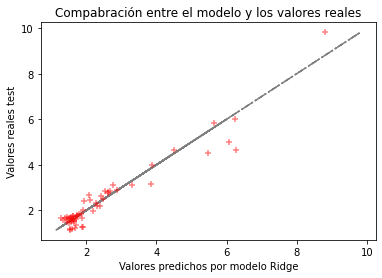

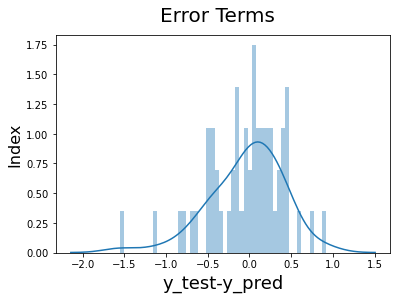

In [31]:
data_total = data_1.merge(data_2, how="left", on="Mes")
data_total.interpolate(method='linear', inplace = True)
data_total = data_total[['Mes', 'Badlar en $', 'TC', 'IPC', 'PBI Real', 'PBI Nominal', 'Tasa de Desempleo', 'Tasa de Incobrabilidad - mora']]
data_total.columns = ['mes', 'badlar', 'tc', 'ipc', 'pbi_real', 'pbi_nominal', 'tasa_desempleo', 'tasa_incobrabilidad' ]

n=2

data_total[f'badlar_{n}'] = data_total['badlar']**n
data_total[f'tc_{n}'] = data_total['tc']**n
data_total[f'ipc_{n}'] = data_total['ipc']**n
data_total[f'pbi_real_{n}'] = data_total['pbi_real']**n
data_total[f'pbi_nominal_{n}'] = data_total['pbi_nominal']**n
data_total[f'tasa_desempleo_{n}'] = data_total['tasa_desempleo']**n


X = data_total.drop(["tasa_incobrabilidad", "mes"],axis=1)
y = data_total["tasa_incobrabilidad"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

# Aplicamos StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

#Regresión Lineal con Regularización Ridge

rlm = linear_model.RidgeCV(alphas=np.linspace(0,0.1, 1000), cv=5, normalize=True,scoring='r2')
ridge_model = rlm.fit(X_train_sc, y_train)
y_pred_ridge = ridge_model.predict(X_test_sc)

print(f"\n\nn: {n}:")
print("R2 train:", ridge_model.score(X_train_sc, y_train).round(5))
print("Best alpha: ", ridge_model.alpha_.round(5))

print("\nTest:")
print('MAE:', mean_absolute_error(y_test, y_pred_ridge).round(5))
print('MSE:', mean_squared_error(y_test, y_pred_ridge).round(5))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_ridge)).round(5))
print('R2:', r2_score(y_test, y_pred_ridge).round(5))

plt.scatter(y_pred_ridge, y_test, s=30, c='r',alpha=0.5, marker='+', zorder=10)
plt.plot(y_test,y_test, '-.',c='grey')
plt.xlabel("Valores predichos por modelo Ridge")
plt.ylabel("Valores reales test")
plt.title('Compabración entre el modelo y los valores reales')
plt.show()

# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred_lasso),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label
plt.show()

In [32]:
X


,badlar,tc,ipc,pbi_real,pbi_nominal,tasa_desempleo,badlar_2,tc_2,ipc_2,pbi_real_2,pbi_nominal_2,tasa_desempleo_2
0,4.01,2.97,11.94,484544.000000,5.033040e+05,12.020000,16.0801,8.8209,142.5636,2.347829e+11,2.533149e+11,144.480400
1,3.27,2.93,12.12,487563.666667,5.057703e+05,12.320000,10.6929,8.5849,146.8944,2.377183e+11,2.558036e+11,151.782400
2,2.92,2.93,12.23,490583.333333,5.082367e+05,12.620000,8.5264,8.5849,149.5729,2.406720e+11,2.583045e+11,159.264400
3,3.09,2.92,12.42,493603.000000,5.107030e+05,12.920000,9.5481,8.5264,154.2564,2.436439e+11,2.608176e+11,166.926400
4,3.92,2.91,12.48,522958.000000,5.423927e+05,12.600000,15.3664,8.4681,155.7504,2.734851e+11,2.941898e+11,158.760000
...,...,...,...,...,...,...,...,...,...,...,...,...
188,29.68,74.18,337.10,611823.666667,2.591042e+07,12.166667,880.9024,5502.6724,113636.4100,3.743282e+11,6.713500e+14,148.027778
189,29.73,76.18,346.60,613801.000000,2.714737e+07,11.700000,883.8729,5803.3924,120131.5600,3.767517e+11,7.369796e+14,136.890000
190,30.68,78.33,359.70,626497.726667,2.755447e+07,11.800000,941.2624,6135.5889,129384.0900,3.924994e+11,7.592489e+14,139.240000
191,33.02,81.30,371.00,639194.453333,2.796157e+07,11.900000,1090.3204,6609.6900,137641.0000,4.085695e+11,7.818497e+14,141.610000


### 6- Persistencia del modelo

Ya que tenemos nuestro modelo final entrenado, lo persistiremos en un archivo utilizando la librería Pickle, como así también nuestro escalador sc.

In [33]:
import pickle
import os


In [34]:
# Guardamos el modelo entrenado en una carpeta que se llama "modelos" que esté a la misma altura que la notebook

with open('ridge_model.pkl', 'wb') as modelo_pkl:
    pickle.dump(ridge_model, modelo_pkl)

# Guardamos también el escalador entrenado, ya que lo vamos a tener que aplicar a los casos nuevos que le pasemos

with open('scaler.pkl', 'wb') as scaler_pkl:
    pickle.dump(sc, scaler_pkl)

In [35]:
# observamos si los archivos se crearon en la carpeta en donde estamos ejecutando la notebook
[x for x in os.listdir() if 'pkl' in x]

['ridge_model.pkl', 'scaler.pkl']